<image src="https://raw.githubusercontent.com/ramiro999/pytorch-exploration/main/images/Banner%20Hands-on-ResNet.png" width=100%>

# <font color='#4C5FDA'> **ResNet: Redes neuronales residuales** </font>

ResNet, o Red Residual, es un tipo de red neuronal convolucional diseñada para facilitar el entrenamiento de redes muy profundas. Fue introducida por Kaiming He y otros en el trabajo <font color="EB9A54">"Deep Residual Learning for Image Recognition"</font> durante el ILSVRC de 2015, donde ganó el primer lugar en varias categorías.

<font color="EB9A54">**¿Por qué utilizar ResNet?**</font>

Facilita el entrenamiento de redes profundas: Uno de los principales desafíos en el entrenamiento de redes profundas es el problema de la desaparición/exploración de gradientes. ResNet aborda esto mediante el uso de conexiones residuales que permiten que los gradientes fluyan directamente a través de las capas sin pasar por transformaciones lineales, facilitando el entrenamiento de redes con cientos o incluso miles de capas.

- Reutilización de características: Las conexiones de salto (skip connections) permiten que la red ajuste la información y reutilice las características aprendidas anteriormente, lo cual es eficaz para la generalización.

- Flexibilidad y adaptabilidad: ResNet ha demostrado ser efectiva en una variedad de tareas de visión por computadora más allá de la clasificación de imágenes, como la detección de objetos y la segmentación semántica.

<font color="EB9A54">**Beneficios sobre otras redes neuronales**</font>

- Reducción del problema del desvanecimiento de gradientes: A diferencia de las redes convencionales donde el gradiente puede desvanecerse a medida que aumenta la profundidad, las conexiones residuales en ResNet permiten que el gradiente se propague eficazmente a través de muchas más capas.

- Mejor rendimiento con mayor profundidad: Mientras que en redes convencionales el rendimiento puede empezar a degradarse o saturarse a medida que la red se profundiza, ResNet puede escalar eficazmente a cientos de capas sin degradación del rendimiento.

- Eficiencia en entrenamiento y convergencia más rápida: Las conexiones residuales mejoran la eficiencia del entrenamiento permitiendo convergencias más rápidas con menores tasas de error.

- Versatilidad y robustez: ResNet ha establecido nuevos estándares en varios benchmarks y competiciones, demostrando su robustez y versatilidad en diferentes dominios de aplicación.

<image src="https://raw.githubusercontent.com/ramiro999/pytorch-exploration/main/images/resnet.png" >

In [48]:
#@title PyTorch stuff
import torch
torch.manual_seed(0)
from torch import optim, nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt


In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [50]:
PATH = '/media/pepe/DataUbuntu/Databases/cifar-10'
TRAIN_SIZE = 50000
VAL_SIZE = 5000
TEST_SIZE = 5000
MINIBATCH_SIZE = 512

transform_cifar10_train = T.Compose([
                T.RandomHorizontalFlip(p=0.3),
                T.ColorJitter(brightness=0.1, contrast=0.1, hue = 0.05),
                T.RandomApply([T.RandomRotation(10), T.Resize(40), T.CenterCrop(32)], p = 0.1),
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262])
            ])
transform_cifar10_test = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(PATH, train=True, download=True,transform=transform_cifar10_train)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, shuffle = True)

# Validation and test sets
test_dataset = datasets.CIFAR10(PATH, train=False, download=True, transform=transform_cifar10_test)
val_dataset, test_dataset = random_split(test_dataset, [VAL_SIZE, TEST_SIZE])

val_loader = DataLoader(val_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

test_loader = DataLoader(test_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
for i,(x, y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

0 torch.Size([512, 3, 32, 32]) torch.Size([512])
1 torch.Size([512, 3, 32, 32]) torch.Size([512])
2 torch.Size([512, 3, 32, 32]) torch.Size([512])
3 torch.Size([512, 3, 32, 32]) torch.Size([512])
4 torch.Size([512, 3, 32, 32]) torch.Size([512])
5 torch.Size([512, 3, 32, 32]) torch.Size([512])
6 torch.Size([512, 3, 32, 32]) torch.Size([512])
7 torch.Size([512, 3, 32, 32]) torch.Size([512])
8 torch.Size([512, 3, 32, 32]) torch.Size([512])
9 torch.Size([392, 3, 32, 32]) torch.Size([392])


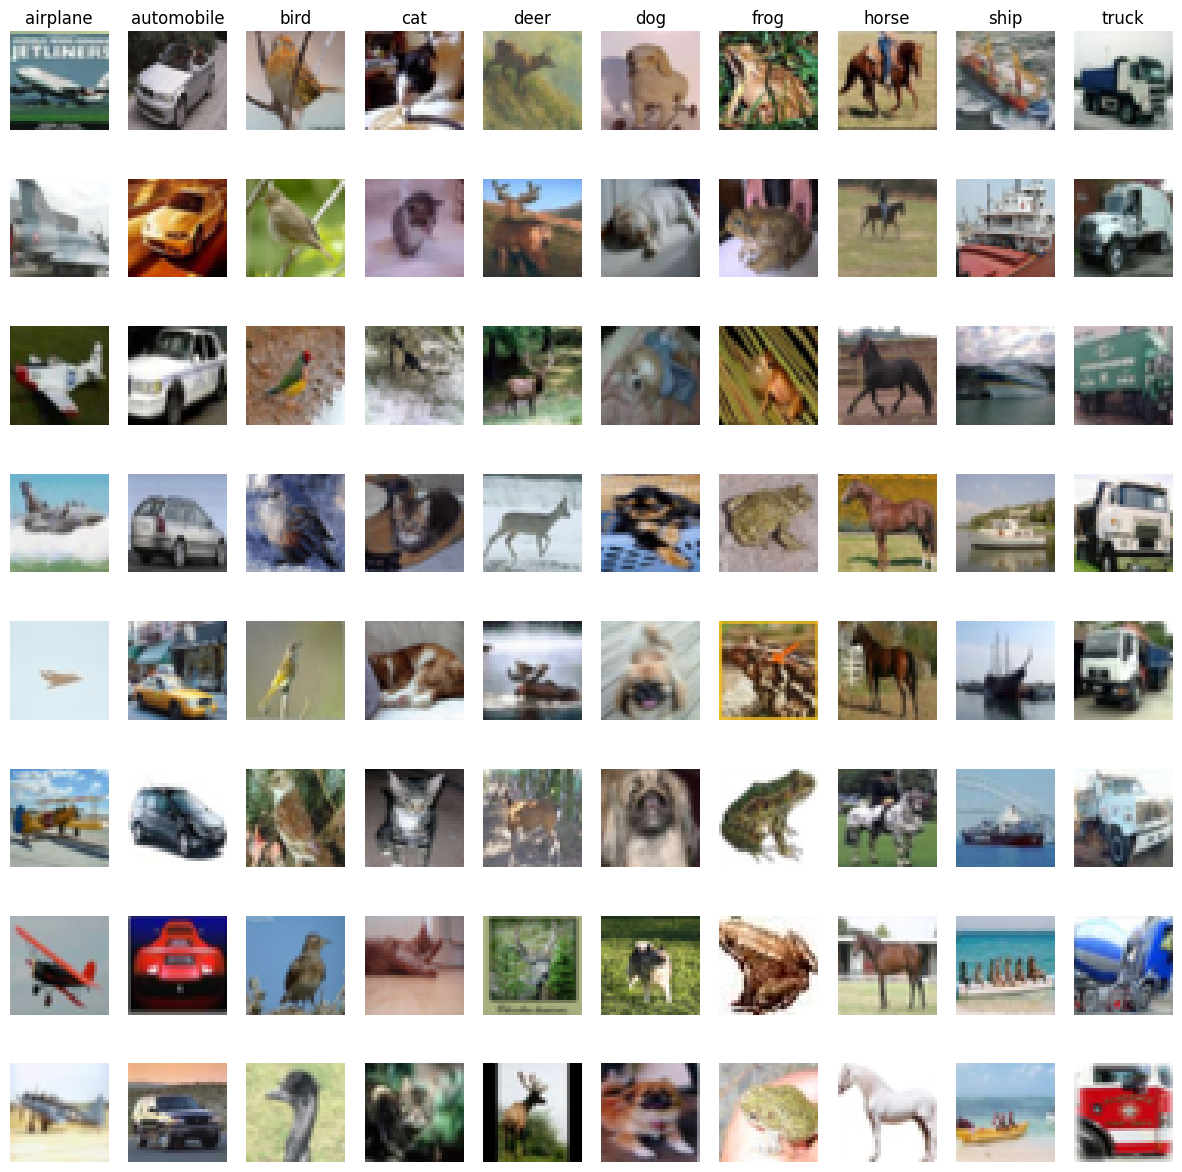

In [52]:
def plot_cifar10_grid():
    classes = train_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(train_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(train_loader.dataset.data[idx])
            plt.axis('off')

            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid()


La imagen muestreada representa un: frog


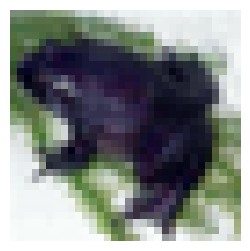

In [53]:
classes = train_loader.dataset.classes
def plot_figure(image):
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

In [54]:
len(val_loader)

10

In [55]:
def accuracy(model, loader):
    '''
    model - PyTorch model
    loader - PyTorch dataloader

    Returns:

    '''
    correct = 0
    total = 0
    cost = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            _, pred = scores.max(dim=1)
            correct += (pred == y).sum()
            total += pred.size(0)
        return cost/len(loader), float(correct)/total

In [56]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)

        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0))
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

#         accuracies.append(acc.item())
        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

In [57]:
def train(model, optimiser, scheduler = None, epochs = 100):
    model = model.to(device = device)
    val_loss_history = []
    train_loss_history = []
    val_acc_history = []
    train_acc_history = []
    lrs = []
    train_cost = 0.
    val_cost = 0.
    train_cost_acum = 0
    for epoch in range(epochs):
        train_correct_num  = 0
        train_total = 0
        train_cost_acum = 0
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            #if using scheduler
            if scheduler: scheduler.step()

            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)
            train_cost_acum += cost.item()
            train_acc = float(train_correct_num)/train_total
#             train_cost = train_cost_acum/mb
            val_cost, val_acc = accuracy(model, val_loader)

            val_loss_history.append(val_cost)
            train_loss_history.append(cost.item())
            val_acc_history.append(val_acc)
            train_acc_history.append(train_acc)
#             lrs.append(scheduler.get_last_lr()[0])
            lrs.append(optimiser.param_groups[0]["lr"])

        #f'last lr: {scheduler.get_last_lr()[0]:6f},

        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/len(train_loader)
        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}, total: {train_total},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs

## <font color='#4C5FDA'> **ResNet56** </font>

In [58]:
conv_k_3 = lambda channel1, channel2, stride: nn.Conv2d(channel1, channel2, stride = stride, kernel_size=3, padding=1)

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
    Implementa un bloque residual que contiene dos capas convolucionales con una conexión residual.
    Se puede modificar el tamaño de los mapas de activación a través de la opción `change_size`.

    Atributos:
        conv1 (nn.Module): Primera capa convolucional del bloque.
        bn1 (nn.Module): Primera capa de normalización por lotes.
        conv2 (nn.Module): Segunda capa convolucional del bloque.
        bn2 (nn.Module): Segunda capa de normalización por lotes.
        residual (nn.Module, opcional): Capa adicional para adaptar las dimensiones del tensor de entrada al tamaño deseado.
    """
    def __init__(self, in_channel, out_channel, stride=1, change_size=True):
        super().__init__()
        self.change_size = change_size
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)

        self.change_size = change_size

        # Condicional para adaptar la dimensión del tensor de entrada al tamaño de salida deseado
        if self.change_size:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.residual = None

    def forward(self, x):
        identity = x if not self.change_size else self.residual(x)  # Calcular la identidad, que es x o una versión adaptada de x si cambia el tamaño
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += identity  # Añadir la identidad al resultado de las capas convolucionales
        return F.relu(y)  # Aplicar la activación ReLU antes de devolver el resultadot


In [60]:
import torch.nn as nn
import torch.nn.functional as F

class ResNet56(nn.Module):
    """
    Implementa una variante del modelo ResNet diseñada específicamente con 56 capas,
    típicamente utilizada para tareas de clasificación de imágenes. Esta configuración usa grupos de
    bloques residuales para aprender características de las imágenes.
    """

    def __init__(self, n=9, num_classes=10):
        """
        Inicializa el modelo ResNet56.

        Parámetros:
        - n (int): Número de bloques residuales en cada uno de los tres grupos de bloques.
        - num_classes (int): Número de clases para la clasificación final.
        """
        super().__init__()
        # Capa convolucional inicial que procesa la imagen de entrada
        self.conv1 = conv_k_3(3, 16, stride=1)  # Capa convolucional definida anteriormente.
        self.bn1 = nn.BatchNorm2d(16)  # Normalización por lotes para las salidas de la primera capa convolucional.

        # Creando tres grupos de bloques residuales
        self.block1 = self.create_block(n=9, in_channel=16, out_channel=16, stride=1, change_size=False)
        self.block2 = self.create_block(n=9, in_channel=16, out_channel=32, stride=2)
        self.block3 = self.create_block(n=9, in_channel=32, out_channel=64, stride=2)

        # Capa completamente conectada final para la clasificación
        self.fc = nn.Linear(64, num_classes)

    def create_block(self, n, in_channel, out_channel, stride, change_size=True):
        """
        Crea un bloque de `n` bloques residuales, donde el primer bloque puede cambiar
        el tamaño de los mapas de características.

        Parámetros:
        - n (int): Número de bloques residuales en el bloque.
        - in_channel (int): Número de canales de entrada.
        - out_channel (int): Número de canales de salida.
        - stride (int): Stride para la convolución en el primer bloque residual.
        - change_size (bool): Si cambiar o no las dimensiones en el primer bloque.
        """
        # Primer bloque que podría cambiar dimensiones
        block = [ResidualBlock(in_channel, out_channel, stride, change_size=change_size)]
        # Bloques restantes con dimensiones consistentes
        for i in range(n-1):
            block.append(ResidualBlock(out_channel, out_channel, stride=1, change_size=False))
        return nn.Sequential(*block)

    def forward(self, x):
        """
        Define el paso hacia adelante del modelo.

        Parámetros:
        - x (Tensor): Tensor de entrada con datos de imagen.

        Devoluciones:
        - Tensor: Tensor de salida después de la clasificación.
        """
        y = F.relu(self.bn1(self.conv1(x)))  # Aplica ReLU después de la conv inicial y norma por lotes
        y = self.block3(self.block2(self.block1(y)))  # Pasa a través de todos los bloques residuales secuencialmente
        y = F.adaptive_avg_pool2d(y, 1)  # Pooling promedio global para reducir cada mapa a un solo valor
        return self.fc(y.view(y.size(0), -1))  # Aplana y pasa a través de la capa FC final para la clasificación


In [61]:
model_resnet56 = ResNet56()
optimizer_resnet56 = torch.optim.SGD(model_resnet56.parameters(),
                                     lr=0.1, momentum=0.95,
                                     weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model_resnet56, optimizer_resnet56, start_val=1e-6, end_val=10)

cost:2.6651, lr: 0.0000, acc: 0.1211
cost:2.6684, lr: 0.0000, acc: 0.1035
cost:2.7392, lr: 0.0000, acc: 0.0879
cost:2.7535, lr: 0.0000, acc: 0.0859
cost:2.7193, lr: 0.0000, acc: 0.1055
cost:2.7677, lr: 0.0000, acc: 0.1113
cost:2.6068, lr: 0.0000, acc: 0.1309
cost:2.6368, lr: 0.0000, acc: 0.1211
cost:2.7375, lr: 0.0000, acc: 0.0723
cost:2.7175, lr: 0.0000, acc: 0.1270
cost:2.7219, lr: 0.0000, acc: 0.1055
cost:2.6956, lr: 0.0000, acc: 0.1230
cost:2.8056, lr: 0.0000, acc: 0.0898
cost:2.7434, lr: 0.0000, acc: 0.1035
cost:2.7555, lr: 0.0000, acc: 0.0957
cost:2.6818, lr: 0.0000, acc: 0.0879
cost:2.7069, lr: 0.0000, acc: 0.1211
cost:2.7009, lr: 0.0000, acc: 0.0996
cost:2.6687, lr: 0.0000, acc: 0.1055
cost:2.6735, lr: 0.0000, acc: 0.0938
cost:2.6271, lr: 0.0000, acc: 0.1055
cost:2.6305, lr: 0.0000, acc: 0.1055
cost:2.6844, lr: 0.0000, acc: 0.0781
cost:2.6891, lr: 0.0000, acc: 0.0781
cost:2.5483, lr: 0.0001, acc: 0.1094
cost:2.5875, lr: 0.0001, acc: 0.0957
cost:2.4976, lr: 0.0001, acc: 0.1211
c

In [62]:
from torchsummary import summary

summary(model_resnet56, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,320
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,320
       BatchNorm2d-6           [-1, 16, 32, 32]              32
     ResidualBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,320
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,320
      BatchNorm2d-11           [-1, 16, 32, 32]              32
    ResidualBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,320
      BatchNorm2d-14           [-1, 16,

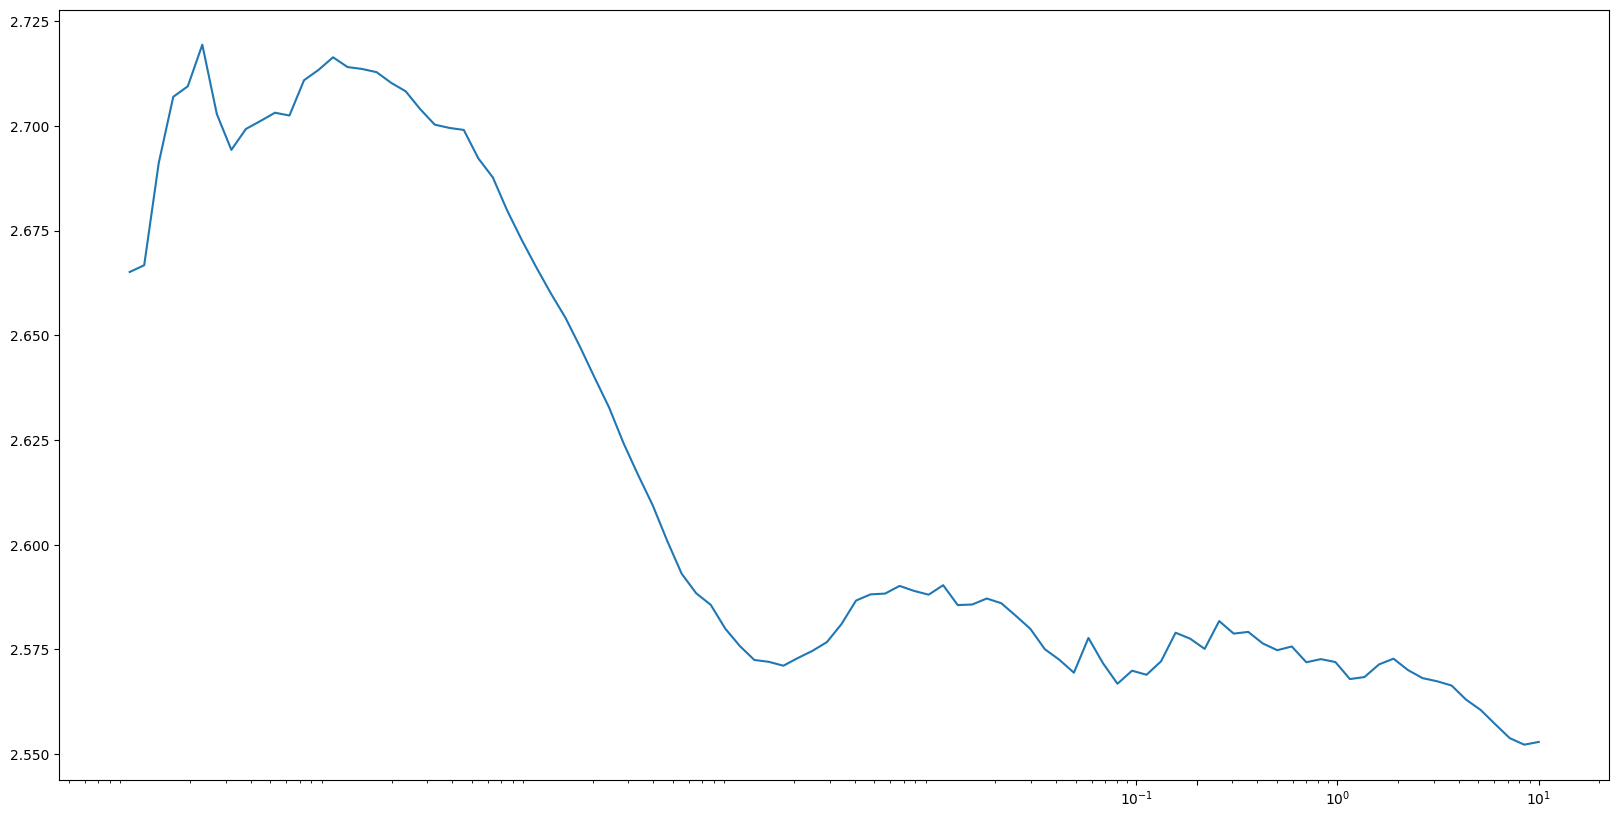

In [63]:
f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
ax1.set_xticks([1e-1,2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

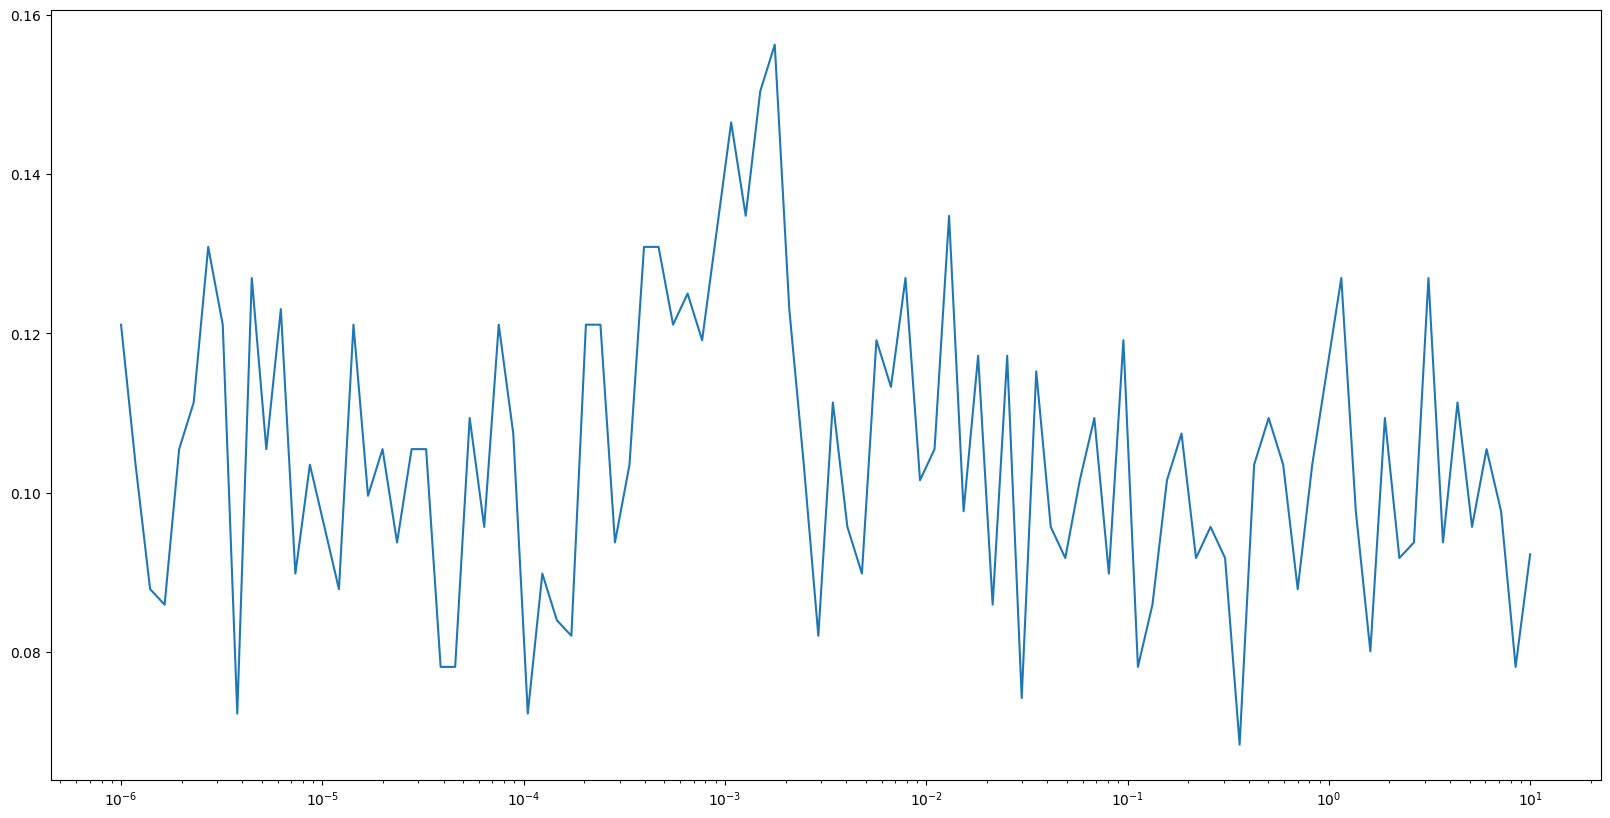

In [64]:
f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, accuracies)
ax1.set_xscale('log')
# ax1.set_xticks([1e-1, 2e-1,5e-1, 7e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

In [65]:
model_resnet56 = ResNet56()
optimiser_resnet56 = torch.optim.SGD(model_resnet56.parameters(),
                                     lr=0.1, momentum=0.95,
                                     weight_decay=1e-4)
epochs = 50
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_resnet56,
                                                max_lr=2e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs = epochs, pct_start=0.43,
                                                div_factor=10,
                                                final_div_factor=1000,
                                                three_phase=True
                                            )
train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs = train(
                                model_resnet56,
                                optimiser=optimiser_resnet56,
                                scheduler=scheduler,
                                epochs = epochs
                                )

KeyboardInterrupt: 

In [66]:
accuracy(model_resnet56, test_loader)

KeyboardInterrupt: 

# <font color='#4C5FDA'> **Referencias** </font>

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. Proceedings of the IEEE conference on computer vision and pattern recognition (CVPR).

https://arxiv.org/abs/1512.03385

---

Canziani, A., Paszke, A., & Culurciello, E. (2016). An Analysis of Deep Neural Network Models for Practical Applications.

https://arxiv.org/abs/1605.07678

---

Fundamentos de la implementación

https://github.com/JACantoral/DL_fundamentals/tree/main
